# Video background subtraction

Singular Value Decomposition (SVD) allows us to decompose an array into a number of components. These components may be ranked according to singular value magnitudes. In many practical applications, the underlying structure of an array is almost completely contained in its first SVD component.

Such is the case for the surveillance camera footage we are about to analyze. The camera responsible for this footage remained completely still during recording, so when we watch the footage we see various subjects moving across a still background. Intuitively, we can think of the background as the underlying structure of our surveillance footage.

We will soon see that SVD lets us cleanly separate the still background from motion, noise, and even corrupt data in our surveillance footage.

In [ ]:
# install required packages if not already present:
Pkg.add("MAT")
Pkg.add("Interact")
Pkg.add("PyPlot")
Pkg.add("Images")

In [1]:
# prepare to plot footage:
using Interact, PyPlot
PyPlot.svg(true) # crispy
set_cmap("gray") # we want grayscale video, not heatmap

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7fef566ea748>)

## Loading data

Video data is stored in `lobby.mat` in the form of a $128\times160\times650$ array.

In [2]:
using MAT
# load 128x160x650 array containing video data:
footage = matread("lobby.mat")["MovMat"];
# footage = matread("xylophone.mat")["MovMat"];
(m,n,numFrames) = size(footage)

(128,160,650)

Let's take a look at this footage. Run the cell below and drag the slider to scrub through the video.

Interact.Slider{Int64}([Reactive.Input{Int64}] 325,"frameNumber",325,1:650)

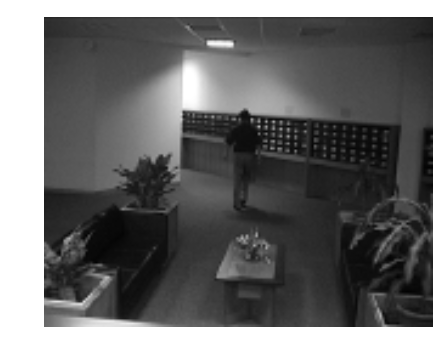

In [4]:
fig = figure(figsize=[5,5])
@manipulate for frameNumber in 1:numFrames; withfig(fig) do
        imshow(footage[:,:,frameNumber])
        axis("off") # no need for axis ticks
    end
end

This footage is pretty clean -- it seems like it would be pretty easy to isolate the background. So let's make things a bit more difficult.

## Adding noise and removing pixels

The power of SVD is especially apparent when the signal (in this case, video data) is noisy or even corrupted. Let's add add random noise and zero out some elements of the video footage data array.

In [5]:
# reshape each frame into a single column vector.
# (this makes it easier to manipulate, and we can
# always reshape the processed data later for
# display purposes)
footageVec = reshape(footage,m*n,numFrames)

σ = 0.3 # Noise standard deviation (type symbol with "\sigma<TAB>")
p = 0.8 # Probability of observing an element of the frame

# mask used to zero out (p*100)% of elements in each frame
mask = rand(size(footageVec)) .< p

# add noise and mask some entries
corruptFootageVec = (footageVec + σ*rand(size(footageVec))).*mask

# return to original footage shape for display purposes:
corruptFootage = reshape(corruptFootageVec,size(footage));

Okay, now how does our footage look?

Interact.Slider{Int64}([Reactive.Input{Int64}] 325,"frameNumber",325,1:650)

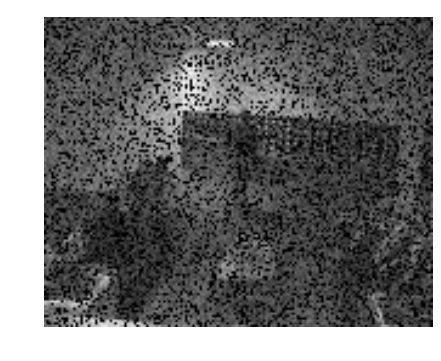

In [6]:
fig = figure(figsize=[5,5])
@manipulate for frameNumber in 1:numFrames; withfig(fig) do
        imshow(corruptFootage[:,:,frameNumber])
        axis("off") # no need for axis ticks
    end
end

How would you go about separating the background from the moving objects, noise, and missing data you see here? Time for some magic.

## Use SVD to isolate video background

In [7]:
# choose the number of components to consider "background":
r = 1

# U,S,V will contain first r components of SVD:
(U,S,V) = svds(corruptFootageVec,nsv=r);

In [8]:
# take first 'r' components as background
backgroundVec = (U*diagm(S))*V'

# calculate residual
residualVec = corruptFootageVec - backgroundVec

# reshape background and residual into footage dimensions
background = reshape(backgroundVec,size(footage))
residual = reshape(residualVec,size(footage));

And just like that, we isolated the background. Not convinced?

## Plot results

Let's take a side-by-side look at the corrupt footage, the background computed via SVD, and the residual (difference between the two).

Interact.Slider{Int64}([Reactive.Input{Int64}] 325,"frameNumber",325,1:650)

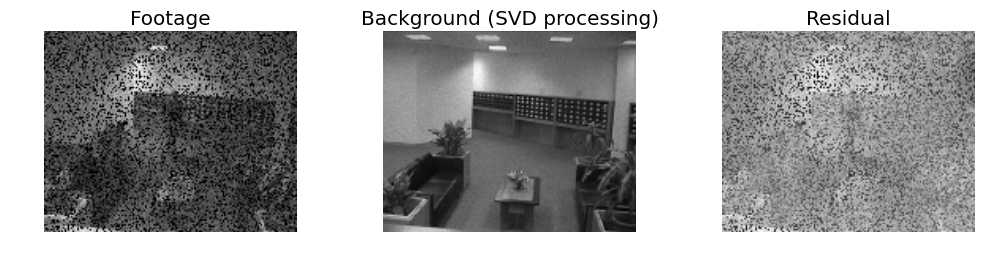

In [9]:
fig = figure(figsize=[10,5])
@manipulate for frameNumber in 1:numFrames; withfig(fig) do
        # side-by-side view of corrupt footage, background,
        # and residual:
        
        subplot(1,3,1)
        # corrupt footage:
        imshow(corruptFootage[:,:,frameNumber])
        axis("off")
        title("Footage")
        
        subplot(1,3,2)
        # background:
        imshow(background[:,:,frameNumber])
        axis("off")
        title("Background (SVD processing)")
        
        subplot(1,3,3)
        # residual:
        imshow(residual[:,:,frameNumber])
        axis("off")
        title("Residual")
        
        # squeeze subplots together:
        tight_layout()
    end
end

## Exercise 1

Vary $\sigma$ and p in "Adding noise and removing pixels" to degrade the footage to your liking. See how much video vandalism you can get away with before our SVD background separation process becomes ineffective.

## Exercise 2

Play with the other video footage file, `xylophone.mat`.